Optimizing the Thickness Distribution of a Cantilever Beam Using the Adjoint Method
[link](http://openmdao.org/twodocs/versions/latest/examples/beam_optimization/beam_optimization.html)
1. Moment of inertia of element: $M_i(h)$ Explicit
2. Compute local stiff matrix:   $K_i(M_i)$ Explicit
3. Assemble global stiff matrix: $K(K_i)$ Explicit
4. solve $K\hat{d}=f$ augmented with the Lagrange multipliers $\hat{d}=\hat{d}(K,f)$ Implicit
5. extract the displacements in $d(\hat{d})$ Explicit
6. objective: compliance $f^Td(d)$ Explicit
7. constraint: volume $V(h)$ Explicit


* Problem:

$\min f^Td$ w.r.t. $h$

such that:     $\sum{h}bL_0=V$, $10^{-2}<h<10$

* Given:
    * $N$: scalar of number of element (because it uses FEM)
    * $f$: vector of forces
    * $L$: scalar of total length of beam
    * $b$: scalar of width of beam
    * $V$: scalar of volume of beam
    * $EI$: scalar of elastic modulus


* Unknown:
    * $d$: vector of displacement $Kd=f$
    * $h$: vector of beam height. **Design Variables**
    * $L_0$: scalar of length of a single element $L_0=L/N$
    * $M$: vector of moment of inertia of element $M=\frac{1}{12}bh^3$
    * $K_i$: matrix of local stiffness
    * $K$: matrix of global stiffness

In [1]:
import numpy as np
N = 50
EI = 1.
L = 1.
b = 0.1
V = 0.01
h = np.ones(N)*0.1

# Moment of inertia of element $M$


$M=\frac{1}{12}bh^3$, $\frac{\partial{M}}{\partial{h}}=\frac{1}{4}bh^2$

In [57]:
M = 1/12*b*h**3

# Compute local stiff matrix:  $K_i$
$dK_i=\frac{EI}{L_0^3}\begin{bmatrix}
    12       & 6L_0    & -12   & 6L_0   \\
    6L_0     & 4L_0^2  & -6L_0 & 2L_0^2 \\
    -12      & -6L_0   & 12    & -6L_0  \\
    6L_0     & 2L_0^2  & -6L_0 & 4L_0^2
\end{bmatrix}$, ${K_i} = dK_i*M_i$, $\frac{\partial{K_i}}{\partial{M_j}}=dK_i*(i=k)+0*(i\neq j)$

[link](https://www.12000.org/my_notes/stiffness_matrix/stiffness_matrix_report.htm),

In [62]:
L0 = L / N
dKi = np.empty((4, 4))
dKi[0, :] = [12 , 6 * L0, -12, 6 * L0]
dKi[1, :] = [6 * L0, 4 * L0 ** 2, -6 * L0, 2 * L0 ** 2]
dKi[2, :] = [-12 , -6 * L0, 12, -6 * L0]
dKi[3, :] = [6 * L0, 2 * L0 ** 2, -6 * L0, 4 * L0 ** 2]
dKi *= E / L0 ** 3

In [67]:
mtx = np.empty((N,4,4,N))
for ind in range(N):
    mtx[ind, :, :, ind] = dKi
i = 1
Ki = dKi * M[i]

#  Assemble global stiff matrix:  $K$

 

$\frac{\partial{K}}{\partial{K_i}}=1$

And augment boundary constraint

#  solve $K\hat{d}=f$  augmented with the Lagrange multipliers

# extract the displacements in  $d$
$d=
\hat{d}[0:2*N]$, $\frac{\partial{d}}{\partial{\hat{d}}}=[1,1,...,1,0,0]$

#  compliance $f^Td$

$\frac{\partial{f^Td}}{\partial{d}}=f$

# Volume $V=\sum{hbL_0}$ 
$V=\sum{hbL_0}$, $\frac{\partial{V}}{\partial{h}}=bL_0$

# In OpenMDAO

In [1]:
# remove all variables
import sys
sys.modules[__name__].__dict__.clear()

##  Moment of inertia of element 

In [2]:
from __future__ import division
import numpy as np
from openmdao.api import ExplicitComponent


class MomentOfInertiaComp(ExplicitComponent):

    def initialize(self):
        self.metadata.declare('num_elements', types=int)
        self.metadata.declare('b')

    def setup(self):
        num_elements = self.metadata['num_elements']

        self.add_input('h', shape=num_elements)
        self.add_output('I', shape=num_elements)

        rows = np.arange(num_elements)
        cols = np.arange(num_elements)
        self.declare_partials('I', 'h', rows=rows, cols=cols)

    def compute(self, inputs, outputs):
        b = self.metadata['b']

        outputs['I'] = 1./12. * b * inputs['h'] ** 3

    def compute_partials(self, inputs, partials):
        b = self.metadata['b']

        partials['I', 'h'] = 1./4. * b * inputs['h'] ** 2

##  Compute local stiff matrix

In [3]:
from __future__ import division
import numpy as np
from openmdao.api import ExplicitComponent


class LocalStiffnessMatrixComp(ExplicitComponent):

    def initialize(self):
        self.metadata.declare('num_elements', types=int)
        self.metadata.declare('E')
        self.metadata.declare('L')

    def setup(self):
        num_elements = self.metadata['num_elements']
        E = self.metadata['E']
        L = self.metadata['L']

        self.add_input('I', shape=num_elements)
        self.add_output('K_local', shape=(num_elements, 4, 4))

        L0 = L / num_elements
        coeffs = np.empty((4, 4))
        coeffs[0, :] = [12 , 6 * L0, -12, 6 * L0]
        coeffs[1, :] = [6 * L0, 4 * L0 ** 2, -6 * L0, 2 * L0 ** 2]
        coeffs[2, :] = [-12 , -6 * L0, 12, -6 * L0]
        coeffs[3, :] = [6 * L0, 2 * L0 ** 2, -6 * L0, 4 * L0 ** 2]
        coeffs *= E / L0 ** 3

        self.mtx = mtx = np.zeros((num_elements, 4, 4, num_elements))
        for ind in range(num_elements):
            self.mtx[ind, :, :, ind] = coeffs

        self.declare_partials('K_local', 'I',
            val=self.mtx.reshape(16 * num_elements, num_elements))

    def compute(self, inputs, outputs):
        num_elements = self.metadata['num_elements']

        outputs['K_local'] = 0
        for ind in range(num_elements):
            outputs['K_local'][ind, :, :] = self.mtx[ind, :, :, ind] * inputs['I'][ind]

##  Assemble global stiff matrix

In [4]:
from __future__ import division
import numpy as np
from openmdao.api import ExplicitComponent


class GlobalStiffnessMatrixComp(ExplicitComponent):

    def initialize(self):
        self.metadata.declare('num_elements', types=int)

    def setup(self):
        num_elements = self.metadata['num_elements']
        num_nodes = num_elements + 1

        self.add_input('K_local', shape=(num_elements, 4, 4))
        self.add_output('K', shape=(2 * num_nodes + 2, 2 * num_nodes + 2))

        rows = np.zeros(16 * num_elements, int)
        indices = np.arange(
            ((2 * num_nodes + 2) * (2 * num_nodes + 2))
        ).reshape((2 * num_nodes + 2, 2 * num_nodes + 2))
        ind1, ind2 = 0, 0
        for ind in range(num_elements):
            ind2 += 16
            ind1_ = 2 * ind
            ind2_ = 2 * ind + 4
            rows[ind1:ind2] = indices[ind1_:ind2_, ind1_:ind2_].flatten()
            ind1 += 16
        cols = np.arange(16 * num_elements)
        self.declare_partials('K', 'K_local', val=1., rows=rows, cols=cols)

        self.set_check_partial_options('K_local', step=1e0)

    def compute(self, inputs, outputs):
        num_elements = self.metadata['num_elements']
        num_nodes = num_elements + 1

        outputs['K'][:, :] = 0.
        for ind in range(num_elements):
            ind1_ = 2 * ind
            ind2_ = 2 * ind + 4

            outputs['K'][ind1_:ind2_, ind1_:ind2_] += inputs['K_local'][ind, :, :]

        outputs['K'][2 * num_nodes + 0, 0] = 1.0
        outputs['K'][2 * num_nodes + 1, 1] = 1.0
        outputs['K'][0, 2 * num_nodes + 0] = 1.0
        outputs['K'][1, 2 * num_nodes + 1] = 1.0

##  solve  Kd̂ =f  augmented with the Lagrange multipliers

In [5]:
from __future__ import division
import numpy as np
from scipy.linalg import lu_factor, lu_solve
from openmdao.api import ImplicitComponent


class StatesComp(ImplicitComponent):

    def initialize(self):
        self.metadata.declare('num_elements', types=int)
        self.metadata.declare('force_vector', types=np.ndarray)

    def setup(self):
        num_elements = self.metadata['num_elements']
        num_nodes = num_elements + 1
        size = 2 * num_nodes + 2

        self.add_input('K', shape=(size, size))
        self.add_output('d', shape=size)

        rows = np.outer(np.arange(size), np.ones(size, int)).flatten()
        cols = np.arange(size ** 2)
        self.declare_partials('d', 'K', rows=rows, cols=cols)

        self.declare_partials('d', 'd')

    def apply_nonlinear(self, inputs, outputs, residuals):
        force_vector = np.concatenate([self.metadata['force_vector'], np.zeros(2)])

        residuals['d'] = np.dot(inputs['K'], outputs['d']) - force_vector

    def solve_nonlinear(self, inputs, outputs):
        force_vector = np.concatenate([self.metadata['force_vector'], np.zeros(2)])

        self.lu = lu_factor(inputs['K'])

        outputs['d'] = lu_solve(self.lu, force_vector)

    def linearize(self, inputs, outputs, partials):
        num_elements = self.metadata['num_elements']
        num_nodes = num_elements + 1
        size = 2 * num_nodes + 2

        self.lu = lu_factor(inputs['K'])

        partials['d', 'K'] = np.outer(np.ones(size), outputs['d']).flatten()
        partials['d', 'd'] = inputs['K']

    def solve_linear(self, d_outputs, d_residuals, mode):
        if mode == 'fwd':
            d_outputs['d'] = lu_solve(self.lu, d_residuals['d'], trans=0)
        else:
            d_residuals['d'] = lu_solve(self.lu, d_outputs['d'], trans=1)

##  extract the displacements in  d(d̂)

In [6]:
from __future__ import division
import numpy as np
from openmdao.api import ExplicitComponent


class DisplacementsComp(ExplicitComponent):

    def initialize(self):
        self.metadata.declare('num_elements', types=int)

    def setup(self):
        num_elements = self.metadata['num_elements']
        num_nodes = num_elements + 1
        size = 2 * num_nodes + 2

        self.add_input('d', shape=size)
        self.add_output('displacements', shape=2 * num_nodes)

        arange = np.arange(2 * num_nodes)
        self.declare_partials('displacements', 'd', val=1., rows=arange, cols=arange)

    def compute(self, inputs, outputs):
        num_elements = self.metadata['num_elements']
        num_nodes = num_elements + 1

        outputs['displacements'] = inputs['d'][:2 * num_nodes]

##   compliance  fTd(d)

In [7]:
from __future__ import division
import numpy as np
from openmdao.api import ExplicitComponent


class ComplianceComp(ExplicitComponent):

    def initialize(self):
        self.metadata.declare('num_elements', types=int)
        self.metadata.declare('force_vector', types=np.ndarray)

    def setup(self):
        num_elements = self.metadata['num_elements']
        num_nodes = num_elements + 1
        force_vector = self.metadata['force_vector']

        self.add_input('displacements', shape=2 * num_nodes)
        self.add_output('compliance')

        self.declare_partials('compliance', 'displacements',
            val=force_vector.reshape((1, 2 * num_nodes)))

    def compute(self, inputs, outputs):
        force_vector = self.metadata['force_vector']

        outputs['compliance'] = np.dot(force_vector, inputs['displacements'])

##  volume  V(h)

In [8]:
from __future__ import division
import numpy as np
from openmdao.api import ExplicitComponent


class VolumeComp(ExplicitComponent):

    def initialize(self):
        self.metadata.declare('num_elements', types=int)
        self.metadata.declare('b', default=1.)
        self.metadata.declare('L')

    def setup(self):
        num_elements = self.metadata['num_elements']
        b = self.metadata['b']
        L = self.metadata['L']
        L0 = L / num_elements

        self.add_input('h', shape=num_elements)
        self.add_output('volume')

        self.declare_partials('volume', 'h', val=b * L0)

    def compute(self, inputs, outputs):
        num_elements = self.metadata['num_elements']
        b = self.metadata['b']
        L = self.metadata['L']
        L0 = L / num_elements

        outputs['volume'] = np.sum(inputs['h'] * b * L0)

## Group together

In [9]:
from __future__ import division
import numpy as np

from openmdao.api import Group, IndepVarComp
class BeamGroup(Group):

    def initialize(self):
        self.metadata.declare('E')
        self.metadata.declare('L')
        self.metadata.declare('b')
        self.metadata.declare('volume')
        self.metadata.declare('num_elements', int)

    def setup(self):
        E = self.metadata['E']
        L = self.metadata['L']
        b = self.metadata['b']
        volume = self.metadata['volume']
        num_elements = self.metadata['num_elements']
        num_nodes = num_elements + 1

        force_vector = np.zeros(2 * num_nodes)
        force_vector[-2] = -1.

        inputs_comp = IndepVarComp()
        inputs_comp.add_output('h', shape=num_elements)
        self.add_subsystem('inputs_comp', inputs_comp)

        I_comp = MomentOfInertiaComp(num_elements=num_elements, b=b)
        self.add_subsystem('I_comp', I_comp)

        comp = LocalStiffnessMatrixComp(num_elements=num_elements, E=E, L=L)
        self.add_subsystem('local_stiffness_matrix_comp', comp)

        comp = GlobalStiffnessMatrixComp(num_elements=num_elements)
        self.add_subsystem('global_stiffness_matrix_comp', comp)

        comp = StatesComp(num_elements=num_elements, force_vector=force_vector)
        self.add_subsystem('states_comp', comp)

        comp = DisplacementsComp(num_elements=num_elements)
        self.add_subsystem('displacements_comp', comp)

        comp = ComplianceComp(num_elements=num_elements, force_vector=force_vector)
        self.add_subsystem('compliance_comp', comp)

        comp = VolumeComp(num_elements=num_elements, b=b, L=L)
        self.add_subsystem('volume_comp', comp)

        self.connect('inputs_comp.h', 'I_comp.h')
        self.connect('I_comp.I', 'local_stiffness_matrix_comp.I')
        self.connect(
            'local_stiffness_matrix_comp.K_local',
            'global_stiffness_matrix_comp.K_local')
        self.connect(
            'global_stiffness_matrix_comp.K',
            'states_comp.K')
        self.connect(
            'states_comp.d',
            'displacements_comp.d')
        self.connect(
            'displacements_comp.displacements',
            'compliance_comp.displacements')
        self.connect(
            'inputs_comp.h',
            'volume_comp.h')

        self.add_design_var('inputs_comp.h', lower=1e-2, upper=10.)
        self.add_objective('compliance_comp.compliance')
        self.add_constraint('volume_comp.volume', equals=volume)

## Run Model 

In [13]:
import numpy as np

from openmdao.api import Problem, ScipyOptimizer

#from openmdao.test_suite.test_examples.beam_optimization.beam_group import BeamGroup

E = 1.
L = 10.
b = 1
volume = 0.1

num_elements = 500

prob = Problem(model=BeamGroup(E=E, L=L, b=b, volume=volume, num_elements=num_elements))

prob.driver = ScipyOptimizer()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['tol'] = 1e-9
prob.driver.options['disp'] = True

prob.setup()

prob.run_driver()
print(prob['inputs_comp.h'])

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 2994247.5588652
            Iterations: 73
            Function evaluations: 568
            Gradient evaluations: 73
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
[0.50493328 0.46185523 0.42021919 0.37730544 0.33448261 0.26834159
 0.22499123 0.18242828 0.17320688 0.13081676 0.08935424 0.08935423
 0.08935421 0.0893542  0.08935418 0.08935417 0.08935415 0.08935414
 0.08935412 0.08935411 0.08935409 0.08935408 0.08935407 0.08935405
 0.08935404 0.08935402 0.08935401 0.08935399 0.08935398 0.08935396
 0.08935395 0.08935394 0.08935392 0.08959962 0.0895996  0.08959959
 0.08959957 0.08959956 0.08959954 0.08959953 0.08959952 0.0895995
 0.08959949 0.08959947 0.08959946 0.08959945 0.11287415 0.12285396
 0.12285395 0.12285394 0.12285392 0.12285391 0.1228539  0.12285388
 0.12285387 0.12285385 0.12285384 0.12285383 0.12285381 0.1228538
 0.12285379 0.12285377 0.1228537

In [16]:
%matplotlib inline

KeyError: '_oh'

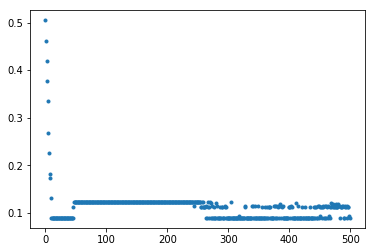

In [17]:
import matplotlib.pyplot as plt
plt.plot(prob['inputs_comp.h'],'.')